Ta thưc hiện install các thư viện cần thiết. Bốn thư viện này đều nằm trong hệ sinh thái của Huggingface dùng để làm việc với các mô hình deep learning trong NLP.

In [1]:
!pip install -q -U datasets
!pip install -q -U accelerate
!pip install -q -U transformers
!pip install -q -U peft

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 32.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.3/168.3 kB 2.4 MB/s eta 0:00:00


# **Load dataset**

Bộ dataset này bao gồm 2 subsets: `rw` và `mt`. Cả 2 subsets đều có cùng training set, chỉ khác validation set và test set:

1. `rw`: Mỗi câu trong `val_set` và `test_set` đều chỉ đề cập đến 1 đối tượng duy nhất và yêu cầu mình tìm sentiment.
2. `mt`: Mỗi câu (sentence) trong `val_set` và `test_set` có thể đề cập cùng lúc nhiều đối tượng khác nhau (mention), nhiệm vụ mình là tìm sentiment của từng đối tượng đang được đề cập trong câu.

Có thể đọc paper để hiểu hơn về dataset: https://aclanthology.org/2021.eacl-main.142.pdf

In [2]:
import pandas as pd
import os
import json
import torch
from typing import Optional, Union
import numpy as np
from datasets import Dataset
from dataclasses import dataclass
from transformers import AutoTokenizer
from transformers import EarlyStoppingCallback
from transformers.tokenization_utils_base import PreTrainedTokenizerBase, PaddingStrategy
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer, DataCollatorWithPadding, AutoModelForSequenceClassification, AutoTokenizer

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
from datasets import load_dataset
dataset_id = "fhamborg/news_sentiment_newsmtsc"
dataset = load_dataset(dataset_id, 'rw')

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

In [4]:
dataset

DatasetDict({
    train: Dataset({
        features: ['mention', 'polarity', 'from', 'to', 'sentence', 'id'],
        num_rows: 8739
    })
    test: Dataset({
        features: ['mention', 'polarity', 'from', 'to', 'sentence', 'id'],
        num_rows: 803
    })
    validation: Dataset({
        features: ['mention', 'polarity', 'from', 'to', 'sentence', 'id'],
        num_rows: 343
    })
})

Quy trình của mình sẽ như sau:

- **Bước 1:** Xây dựng mô hình.

- **Bước 2:** Train mô hình trên tập dữ liệu training (`X_train` và `y_train`).

- **Bước 3:** Sử dụng tập `X_val` và `y_val` để điều chỉnh siêu tham số (hyperparameters) cho mô hình (Có thể sử dụng `Grid Search` hoặc `Random Search` rồi dùng `Cross-validation` để đánh giá).

- **Bước 4:** Sử dụng tập `X_test` và `y_test` để đánh giá trên các metrics được định sẵn (bao gồm accuracy, precision, average recall, macroF1). Chỉ sử dụng tập test ***1 lần duy nhất*** sau khi đã train và điều chỉnh siêu tham số để tránh overfit trên tập test.

- **Bước 5:** Thực hiện phân tích thủ công các câu mà mô hình dự đoán sai nhãn (ví dụ như xuất hiện nhiều câu có thể vừa POSITIVE vừa NEUTRAL dẫn đến model bị confused), số lượng khoảng 50 câu ngẫu nhiên trong các câu bị dự đoán sai. Bước này có thể dựa vào chương 6 trong paper https://aclanthology.org/2021.eacl-main.142.pdf để thực hiện.

Với mỗi bước mọi người nhớ comment để giải thích code, ngoài ra phải vẽ thêm biểu đồ thể hiện các metrics trong quá trình training, validate cũng như test. Sau khi hoàn thành cả 5 bước, mọi người tiến hành viết báo cáo cho mô hình của mình theo từng phần tương ứng nhe ***(Bước 1 - 4 là phần 4.1: Fine-tuning, Bước 5 là phần 5: Phân tích lỗi)***. Nếu còn thời gian thì có thể thêm các mô hình ngôn ngữ lớn (như LLaMA2, FlanT5) cho bài mình.

# **Tiền xử lý - EDA**

### 1. EDA

In [ ]:
train_dataset = dataset['train']
test_dataset = dataset['test']
val_dataset = dataset['validation']

# Tạo dataframe để hiển thị dữ liệu
df_train = pd.DataFrame(train_dataset)
df_val = pd.DataFrame(val_dataset)
df_test = pd.DataFrame(test_dataset)

In [ ]:
df_train['polaritys'] = df_train['polarity'].replace({
   -1: '(Negative)',
    0: '(Neutral)',
    1: '(Positive)'})
df_val['polaritys'] = df_val['polarity'].replace({
   -1: '(Negative)',
    0: '(Neutral)',
    1: '(Positive)'})
df_test['polaritys'] = df_test['polarity'].replace({
   -1: '(Negative)',
    0: '(Neutral)',
    1: '(Positive)'})

In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import pandas as pd

# Lấy các giá trị duy nhất từ cột 'polaritys' của df_train
unique_values_train = df_train['polaritys'].unique()

# Mỗi giá trị polarity lấy một màu sắc duy nhất
color_mapping = {value: color for value, color in zip(unique_values_train, px.colors.qualitative.Plotly[:len(unique_values_train)])}

# Khởi tạo đối tượng subplot
fig = make_subplots(rows=1, cols=3, subplot_titles=['Training Data', 'Test Data', 'Validation Data'])

# Duyệt qua các tập dữ liệu (train, test, val)
for i, df in enumerate([df_train, df_test, df_val]):
    # Tạo biểu đồ thanh cho 'polaritys'
    polarity_counts = df['polaritys'].value_counts().reset_index()
    polarity_counts.columns = ['Sentiment', 'Count']
    polarity_counts['Color'] = polarity_counts['Sentiment'].map(color_mapping)
    polarity_counts['Sentiment'] = pd.Categorical(polarity_counts['Sentiment'], categories=unique_values_train, ordered=True)
    polarity_counts = polarity_counts.sort_values('Sentiment')

    # Thêm subplot
    fig.add_trace(
        go.Bar(x=polarity_counts['Sentiment'], y=polarity_counts['Count'],
               marker_color=polarity_counts['Color']), row=1, col=i + 1)

# Cập nhật bố cục
fig.update_layout(
    xaxis_title_text='Sentiment',
    yaxis_title_text='Count',
    title_text='Distribution of Polaritys in Training, Validation, and Test Data',
    barmode='group',
    width=1400,
    height=600)
fig.show()

In [ ]:
df_train = df_train.drop('polaritys', axis=1)
df_test = df_test.drop('polaritys', axis=1)

## **2. Tiền xử lý**
- Chuyển 'polarity': cảm xúc của câu liên quan đến TSC (-1 = tiêu cực, 0 = trung lập, 1 = tích cực) thành 0,1,2
- Tokenize các 'sentences' để thuận tiện cho việc chạy các mô hình,  cũng như chuyển về dạng lower.

In [ ]:
# Xem tập train
df_train.head()

,mention,polarity,from,to,sentence,id
0,Winner,0,0,6,Winner wrote that she had a 30-minute private ...,allsides_1000_401_25_Reality Leigh Winner_0_6
1,She,-1,0,3,She also recently referred to President Trump ...,allsides_1000_401_3_Reality Leigh Winner_0_3
2,President Trump,-1,30,45,She also recently referred to President Trump ...,allsides_1000_401_3_’ Trump_30_45
3,Hillary Clinton,-1,0,15,Hillary Clinton blamed the Democratic National...,allsides_1018_408_1_Hillary Clinton_2_17
4,Facebook,-1,58,66,Hillary Clinton blamed the Democratic National...,allsides_1018_408_1_Facebook_60_68


In [ ]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.probability import FreqDist
import nltk
nltk.download('punkt')
nltk.download('stopwords')
import re

ptoi = {-1: 0, 0: 1, 1: 2}

# Tạo hàm để chuyển đổi giá trị 'polarity' và tokenize các câu trong 'sentences', chuyển về dạng lower
def map_polarity_and_tokenize(example):
    example['polarity'] = ptoi[example['polarity']]

    # Tokenize ở mức độ word_level
    tokenized_sentence = word_tokenize(example['sentence'])

    # Loại bỏ những dấu câu và chuyển về lowercase
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word.lower() for word in tokenized_sentence if word.isalpha() and word.lower() not in stop_words]
    example['sentence'] = filtered_tokens
    return example

# Chạy hàm với bộ data
tokenized_datasets = dataset.map(map_polarity_and_tokenize)
print(tokenized_datasets)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
Parameter 'function'=<function map_polarity_and_tokenize at 0x7e1a1b5484c0> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


Map:   0%|          | 0/8739 [00:00<?, ? examples/s]

Map:   0%|          | 0/803 [00:00<?, ? examples/s]

Map:   0%|          | 0/343 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['mention', 'polarity', 'from', 'to', 'sentence', 'id'],
        num_rows: 8739
    })
    test: Dataset({
        features: ['mention', 'polarity', 'from', 'to', 'sentence', 'id'],
        num_rows: 803
    })
    validation: Dataset({
        features: ['mention', 'polarity', 'from', 'to', 'sentence', 'id'],
        num_rows: 343
    })
})


In [ ]:
# Cập nhật lại với bộ dữ liệu được preprocess
train_dataset = tokenized_datasets['train']
test_dataset = tokenized_datasets['test']
val_dataset = tokenized_datasets['validation']

# Tạo dataframe để hiển thị dữ liệu
df_train = pd.DataFrame(train_dataset)
df_val = pd.DataFrame(val_dataset)
df_test = pd.DataFrame(test_dataset)

In [ ]:
# Kiểm tra lại tập train
df_train.head()

,mention,polarity,from,to,sentence,id
0,Winner,1,0,6,"[winner, wrote, private, meeting, republican, ...",allsides_1000_401_25_Reality Leigh Winner_0_6
1,She,0,0,3,"[also, recently, referred, president, trump, p...",allsides_1000_401_3_Reality Leigh Winner_0_3
2,President Trump,0,30,45,"[also, recently, referred, president, trump, p...",allsides_1000_401_3_’ Trump_30_45
3,Hillary Clinton,0,0,15,"[hillary, clinton, blamed, democratic, nationa...",allsides_1018_408_1_Hillary Clinton_2_17
4,Facebook,0,58,66,"[hillary, clinton, blamed, democratic, nationa...",allsides_1018_408_1_Facebook_60_68


In [ ]:
print(df_train['sentence'].iloc[0])

['winner', 'wrote', 'private', 'meeting', 'republican', 'lawmaker', 'state', 'policy', 'director']


- Vẽ wordcloud

In [ ]:
from datasets import load_dataset, concatenate_datasets
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords

# Gộp 3 bộ dữ liệu lại
combined_dataset = concatenate_datasets([tokenized_datasets["train"], tokenized_datasets["test"], tokenized_datasets["validation"]])

# Tạo DataFrame
df = pd.DataFrame({'sentence': combined_dataset['sentence'],
                   'polarity': combined_dataset['polarity'],
                   'mention': combined_dataset['mention'],
                   'from': combined_dataset['from'],
                   'to': combined_dataset['to'],
                   'id': combined_dataset['id']})
df.head()

,sentence,polarity,mention,from,to,id
0,"[winner, wrote, private, meeting, republican, ...",1,Winner,0,6,allsides_1000_401_25_Reality Leigh Winner_0_6
1,"[also, recently, referred, president, trump, p...",0,She,0,3,allsides_1000_401_3_Reality Leigh Winner_0_3
2,"[also, recently, referred, president, trump, p...",0,President Trump,30,45,allsides_1000_401_3_’ Trump_30_45
3,"[hillary, clinton, blamed, democratic, nationa...",0,Hillary Clinton,0,15,allsides_1018_408_1_Hillary Clinton_2_17
4,"[hillary, clinton, blamed, democratic, nationa...",0,Facebook,58,66,allsides_1018_408_1_Facebook_60_68


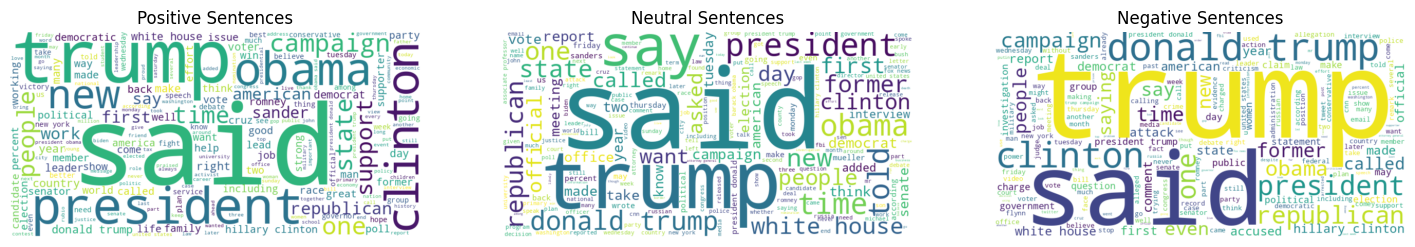

In [ ]:
# Tạo hàm để chuyển đổi câu thành chữ
def list_to_str(sentence_list):
    return ' '.join(map(str, sentence_list))

# Tạo word cloud cho positive sentences
positive_sentences = df[df['polarity'] == 2]['sentence'].apply(list_to_str)
positive_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(positive_sentences))

# Tạo word cloud cho neutral sentences
neutral_sentences = df[df['polarity'] == 1]['sentence'].apply(list_to_str)
neutral_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(neutral_sentences))

# Tạo word cloud cho negative sentences
negative_sentences = df[df['polarity'] == 0]['sentence'].apply(list_to_str)
negative_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(negative_sentences))

plt.figure(figsize=(18, 6))
# Positive Sentences
plt.subplot(1, 3, 1)
plt.imshow(positive_wordcloud, interpolation='bilinear')
plt.title('Positive Sentences')
plt.axis('off')
# Neutral Sentences
plt.subplot(1, 3, 2)
plt.imshow(neutral_wordcloud, interpolation='bilinear')
plt.title('Neutral Sentences')
plt.axis('off')
# Negative Sentences
plt.subplot(1, 3, 3)
plt.imshow(negative_wordcloud, interpolation='bilinear')
plt.title('Negative Sentences')
plt.axis('off')
plt.show()

# **Model**

Ta sẽ sử dụng cột `sentence` cho X (biến độc lập) và cột `polarity` cho y (biến target).

In [ ]:
# Chia tập train test
X_train, X_val, X_test = tokenized_datasets['train']['sentence'], tokenized_datasets['validation']['sentence'], tokenized_datasets['test']['sentence']
y_train, y_val, y_test = tokenized_datasets['train']['polarity'], tokenized_datasets['validation']['polarity'], tokenized_datasets['test']['polarity']

## 1. XGBoost

In [ ]:
import xgboost as xgb
print(X_train)

[['winner', 'wrote', 'private', 'meeting', 'republican', 'lawmaker', 'state', 'policy', 'director'], ['also', 'recently', 'referred', 'president', 'trump', 'piece', 'shit', 'position', 'dakota', 'access', 'pipeline', 'dapl', 'protests'], ['also', 'recently', 'referred', 'president', 'trump', 'piece', 'shit', 'position', 'dakota', 'access', 'pipeline', 'dapl', 'protests'], ['hillary', 'clinton', 'blamed', 'democratic', 'national', 'committee', 'facebook', 'conspiracy', 'site', 'infowars', 'wednesday', 'election', 'defeat', 'interview', 'pointed', 'total', 'alleged', 'guilty', 'parties', 'big', 'loss'], ['hillary', 'clinton', 'blamed', 'democratic', 'national', 'committee', 'facebook', 'conspiracy', 'site', 'infowars', 'wednesday', 'election', 'defeat', 'interview', 'pointed', 'total', 'alleged', 'guilty', 'parties', 'big', 'loss'], ['related', 'damning', 'stories', 'wikileaks', 'event', 'clinton', 'also', 'attacked', 'facebook', 'twitter', 'bots', 'new', 'york', 'times', 'steve', 'banno

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

# Chuyển đổi những câu được tokenize thành một đoạn text
X_train_text = [' '.join(sentence) for sentence in X_train]
X_val_text = [' '.join(sentence) for sentence in X_val]
X_test_text = [' '.join(sentence) for sentence in X_test]

# Sử dụng CountVectorizer để mã hóa đoạn text vừa có
vectorizer = CountVectorizer()
X_train_matrix = vectorizer.fit_transform(X_train_text)
X_val_matrix = vectorizer.transform(X_val_text)
X_test_matrix = vectorizer.transform(X_test_text)

- Default

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report

# Định nghĩa lưới tham số
param_grid = {
    'max_depth': [None, 3, 5, 7],
    'learning_rate': [0.1, 0.01],
    'n_estimators': [None, 50, 100, 200],}

# Tạo mô hình XGBoost
xgb_classifier = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')

# GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb_classifier,
    param_grid=param_grid,
    scoring='accuracy',
    cv=3,
    verbose=1)

# Huấn luyện GridSearchCV trên dữ liệu train
grid_search.fit(X_train_matrix, y_train)

# Lấy ra các tham số tốt nhất
xg_best_params = grid_search.best_params_
xg_best_estimator = grid_search.best_estimator_

print("Các Tham Số Tốt Nhất:", xg_best_params)

Fitting 3 folds for each of 32 candidates, totalling 96 fits
Các Tham Số Tốt Nhất: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200}


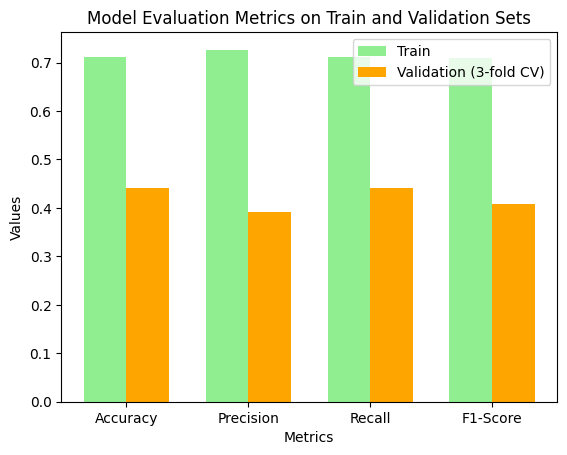

In [ ]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


# Đánh giá mô hình trên tập train
y_pred_train = xg_best_estimator.predict(X_train_matrix)
accuracy_train = accuracy_score(y_train, y_pred_train)
precision_train = precision_score(y_train, y_pred_train, average='weighted')
recall_train = recall_score(y_train, y_pred_train, average='weighted')
f1_train = f1_score(y_train, y_pred_train, average='weighted')

# Đánh giá mô hình trên tập validation (sử dụng 3-fold cross-validation)
y_pred_val_cv = cross_val_predict(xg_best_estimator, X_val_matrix, y_val, cv=3)
accuracy_val_cv = accuracy_score(y_val, y_pred_val_cv)
precision_val_cv = precision_score(y_val, y_pred_val_cv, average='weighted')
recall_val_cv = recall_score(y_val, y_pred_val_cv, average='weighted')
f1_val_cv = f1_score(y_val, y_pred_val_cv, average='weighted')

# Xây dựng mảng chứa các giá trị đánh giá
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
train_values = [accuracy_train, precision_train, recall_train, f1_train]
val_values = [accuracy_val_cv, precision_val_cv, recall_val_cv, f1_val_cv]

# Tạo bar chart
bar_width = 0.35
index = np.arange(len(metrics))

plt.bar(index, train_values, bar_width, label='Train', color='lightgreen')
plt.bar(index + bar_width, val_values, bar_width, label='Validation (3-fold CV)', color='orange')

plt.xlabel('Metrics')
plt.ylabel('Values')
plt.title('Model Evaluation Metrics on Train and Validation Sets')
plt.xticks(index + bar_width / 2, metrics)
plt.legend()
plt.savefig('xgboost-default.pdf', bbox_inches='tight')
# plt.show()

In [ ]:
# best_estimator = {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200}

- L1

In [ ]:
# Tạo các giá trị L1 để bổ sung vào mô hình
param_grid_l1 = {
    'reg_alpha': [0.01, 0.1, 0.5, 1],}

# Sử dụng GridSearch vào mô hình có tham số trước đó
grid_search_l1 = GridSearchCV(
    estimator=xg_best_estimator,
    param_grid=param_grid_l1,
    scoring='accuracy',
    cv=3,
    verbose=1)

# Huấn luyện GridSearchCV trên dữ liệu train
grid_search_l1.fit(X_train_matrix, y_train)

# Lấy ra các tham số tốt nhất
xg_best_params_l1 = grid_search_l1.best_params_
xg_best_estimator_l1 = grid_search_l1.best_estimator_

print("Best Parameters with L1 and L2 regularization:", xg_best_params_l1)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best Parameters with L1 and L2 regularization: {'reg_alpha': 0.01}


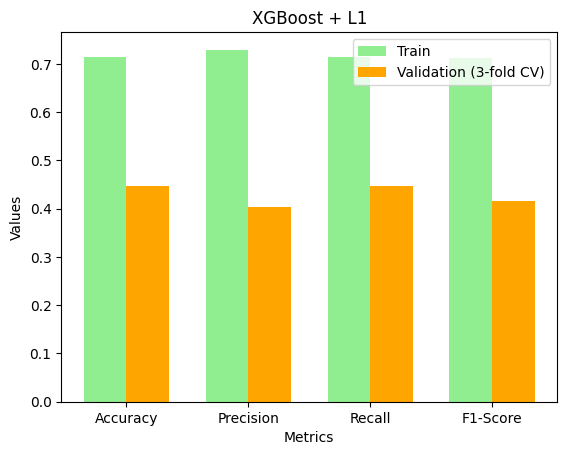

In [ ]:
from sklearn.model_selection import cross_val_predict, cross_val_score

# Đánh giá mô hình trên tập train
y_pred_train = xg_best_estimator_l1.predict(X_train_matrix)
accuracy_train = accuracy_score(y_train, y_pred_train)
precision_train = precision_score(y_train, y_pred_train, average='weighted')
recall_train = recall_score(y_train, y_pred_train, average='weighted')
f1_train = f1_score(y_train, y_pred_train, average='weighted')

# Đánh giá mô hình trên tập validation (sử dụng 3-fold cross-validation)
y_pred_val_cv = cross_val_predict(xg_best_estimator_l1, X_val_matrix, y_val, cv=3)
accuracy_val_cv = accuracy_score(y_val, y_pred_val_cv)
precision_val_cv = precision_score(y_val, y_pred_val_cv, average='weighted')
recall_val_cv = recall_score(y_val, y_pred_val_cv, average='weighted')
f1_val_cv = f1_score(y_val, y_pred_val_cv, average='weighted')

# Tính giá trị trung bình của độ chính xác trên tập validation (3-fold cross-validation)
mean_accuracy_val_cv = np.mean(cross_val_score(xg_best_estimator_l1, X_val_matrix, y_val, cv=3, scoring='accuracy'))

# Tạo mảng chứa các giá trị đánh giá
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
train_values = [accuracy_train, precision_train, recall_train, f1_train]
val_values = [mean_accuracy_val_cv, precision_val_cv, recall_val_cv, f1_val_cv]

# Tạo bar chart
bar_width = 0.35
index = np.arange(len(metrics))

plt.bar(index, train_values, bar_width, label='Train', color='lightgreen')
plt.bar(index + bar_width, val_values, bar_width, label='Validation (3-fold CV)', color='orange')

plt.xlabel('Metrics')
plt.ylabel('Values')
plt.title('XGBoost + L1')
plt.xticks(index + bar_width / 2, metrics)
plt.legend()
plt.savefig('xgboost-l1.pdf', bbox_inches='tight')
# plt.show()

- L2

In [ ]:
# Tạo các giá trị L2 để bổ sung vào mô hình
param_grid_l2 = {
    'reg_lambda': [0.01, 0.1, 0.5, 1]}

# Sử dụng GridSearch vào mô hình có tham số trước đó
grid_search_l2 = GridSearchCV(
    estimator=xg_best_estimator,
    param_grid=param_grid_l2,
    scoring='accuracy',
    cv=3,
    verbose=1)

# Huấn luyện GridSearchCV trên dữ liệu train
grid_search_l2.fit(X_train_matrix, y_train)

# Lấy ra các tham số tốt nhất
xg_best_params_l2 = grid_search_l2.best_params_
xg_best_estimator_l2 = grid_search_l2.best_estimator_

print("Best Parameters with L1 and L2 regularization:", xg_best_estimator_l2)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best Parameters with L1 and L2 regularization: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=None, num_parallel_tree=None, objective='multi:softprob', ...)


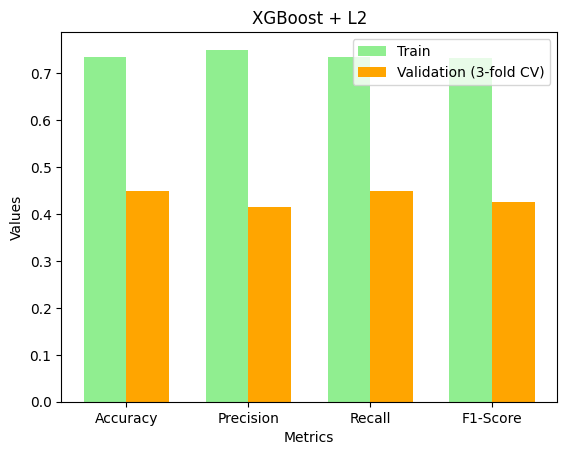

In [ ]:
# Đánh giá mô hình trên tập train
y_pred_train = xg_best_estimator_l2.predict(X_train_matrix)
accuracy_train = accuracy_score(y_train, y_pred_train)
precision_train = precision_score(y_train, y_pred_train, average='weighted')
recall_train = recall_score(y_train, y_pred_train, average='weighted')
f1_train = f1_score(y_train, y_pred_train, average='weighted')

# Đánh giá mô hình trên tập validation (sử dụng 3-fold cross-validation)
y_pred_val_cv = cross_val_predict(xg_best_estimator_l2, X_val_matrix, y_val, cv=3)
accuracy_val_cv = accuracy_score(y_val, y_pred_val_cv)
precision_val_cv = precision_score(y_val, y_pred_val_cv, average='weighted')
recall_val_cv = recall_score(y_val, y_pred_val_cv, average='weighted')
f1_val_cv = f1_score(y_val, y_pred_val_cv, average='weighted')

# Tính giá trị trung bình của độ chính xác trên tập validation (3-fold cross-validation)
mean_accuracy_val_cv = np.mean(cross_val_score(xg_best_estimator_l2, X_val_matrix, y_val, cv=3, scoring='accuracy'))

# Tạo mảng chứa các giá trị đánh giá
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
train_values = [accuracy_train, precision_train, recall_train, f1_train]
val_values = [mean_accuracy_val_cv, precision_val_cv, recall_val_cv, f1_val_cv]

# Tạo bar chart
bar_width = 0.35
index = np.arange(len(metrics))

plt.bar(index, train_values, bar_width, label='Train', color='lightgreen')
plt.bar(index + bar_width, val_values, bar_width, label='Validation (3-fold CV)', color='orange')

plt.xlabel('Metrics')
plt.ylabel('Values')
plt.title('XGBoost + L2')
plt.xticks(index + bar_width / 2, metrics)
plt.legend()
plt.savefig('xgboost-l2.pdf', bbox_inches='tight')
# plt.show()

- L1 + L2

In [ ]:
# Tạo các giá trị L2 để bổ sung vào mô hình
param_grid_l1_l2 = {
    'reg_alpha': [0.01, 0.1, 0.5, 1],
    'reg_lambda': [0.01, 0.1, 0.5, 1]}

# Sử dụng GridSearch vào mô hình có tham số trước đó
grid_search_l1_l2 = GridSearchCV(
    estimator=xg_best_estimator,
    param_grid=param_grid_l1_l2,
    scoring='accuracy',
    cv=3,
    verbose=1)

# Huấn luyện GridSearchCV trên dữ liệu train
grid_search_l1_l2.fit(X_train_matrix, y_train)

# Lấy ra các tham số tốt nhất
xg_best_params_l1_l2 = grid_search_l1_l2.best_params_
xg_best_estimator_l1_l2 = grid_search_l1_l2.best_estimator_

print("Best Parameters with L1 and L2 regularization:", xg_best_params_l1_l2)

Fitting 3 folds for each of 16 candidates, totalling 48 fits
Best Parameters with L1 and L2 regularization: {'reg_alpha': 0.1, 'reg_lambda': 0.5}


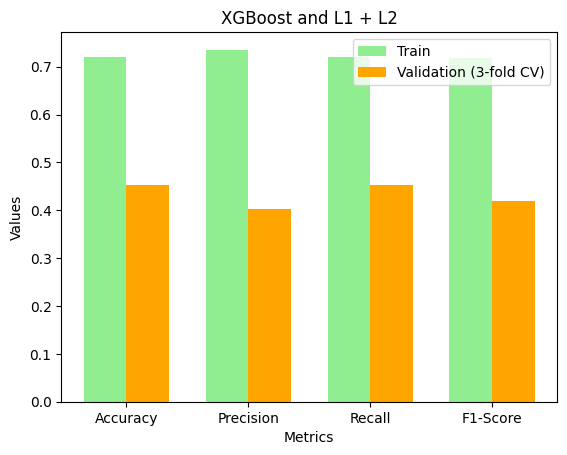

In [ ]:
# Đánh giá mô hình trên tập train
y_pred_train = xg_best_estimator_l1_l2.predict(X_train_matrix)
accuracy_train = accuracy_score(y_train, y_pred_train)
precision_train = precision_score(y_train, y_pred_train, average='weighted')
recall_train = recall_score(y_train, y_pred_train, average='weighted')
f1_train = f1_score(y_train, y_pred_train, average='weighted')

# Đánh giá mô hình trên tập validation (sử dụng 3-fold cross-validation)
y_pred_val_cv = cross_val_predict(xg_best_estimator_l1_l2, X_val_matrix, y_val, cv=3)
accuracy_val_cv = accuracy_score(y_val, y_pred_val_cv)
precision_val_cv = precision_score(y_val, y_pred_val_cv, average='weighted')
recall_val_cv = recall_score(y_val, y_pred_val_cv, average='weighted')
f1_val_cv = f1_score(y_val, y_pred_val_cv, average='weighted')

# Tính giá trị trung bình của độ chính xác trên tập validation (3-fold cross-validation)
mean_accuracy_val_cv = np.mean(cross_val_score(xg_best_estimator_l1_l2, X_val_matrix, y_val, cv=3, scoring='accuracy'))

# Tạo mảng chứa các giá trị đánh giá
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
train_values = [accuracy_train, precision_train, recall_train, f1_train]
val_values = [mean_accuracy_val_cv, precision_val_cv, recall_val_cv, f1_val_cv]

# Tạo bar chart
bar_width = 0.35
index = np.arange(len(metrics))

plt.bar(index, train_values, bar_width, label='Train', color='lightgreen')
plt.bar(index + bar_width, val_values, bar_width, label='Validation (3-fold CV)', color='orange')

plt.xlabel('Metrics')
plt.ylabel('Values')
plt.title('XGBoost and L1 + L2')
plt.xticks(index + bar_width / 2, metrics)
plt.legend()
plt.savefig('xgboost-l1-l2.pdf', bbox_inches='tight')
# plt.show()

### - Chạy trên tập Test

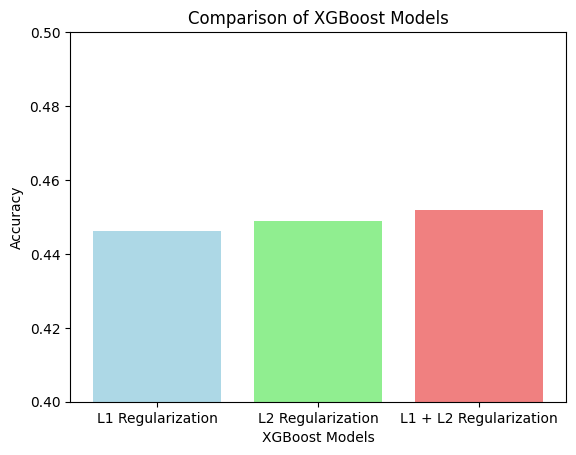

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.metrics import accuracy_score

# List of your XGBoost models
models = [xg_best_estimator_l1, xg_best_estimator_l2, xg_best_estimator_l1_l2]
model_names = ['L1 Regularization', 'L2 Regularization', 'L1 + L2 Regularization']

# Lists to store accuracy values
accuracy_values = []

# Evaluate and store accuracy for each model
for model in models:
    y_pred_val_cv = cross_val_predict(model, X_val_matrix, y_val, cv=3)
    accuracy = accuracy_score(y_val, y_pred_val_cv)
    accuracy_values.append(accuracy)

# Plotting
plt.bar(model_names, accuracy_values, color=['lightblue', 'lightgreen', 'lightcoral'])
plt.xlabel('XGBoost Models')
plt.ylabel('Accuracy')
plt.title('Comparison of XGBoost Models')
plt.ylim([0.4, 0.5])  # Set the y-axis limit to represent accuracy percentage
# plt.show()
plt.savefig('xgboost-compare.pdf', bbox_inches='tight')

In [ ]:
from xgboost import XGBClassifier
import time

# Ghi lại thời điểm bắt đầu
start_time = time.time()

# Khởi tạo mô hình XGBoost với các tham số tốt nhất
xg_best_estimator_l1_l2 = XGBClassifier(
    learning_rate=0.1,
    max_depth=7,
    n_estimators=200,
    reg_alpha=0.1,
    reg_lambda=0.5,
)

# Huấn luyện mô hình trên dữ liệu huấn luyện
xg_best_estimator_l1_l2.fit(X_train_matrix, y_train)

# Ghi lại thời điểm kết thúc
end_time = time.time()

# Tính thời gian chạy
execution_time = end_time - start_time
print(f"Thời gian chạy của mô hình: {execution_time} giây")

Thời gian chạy của mô hình: 36.34757900238037 giây


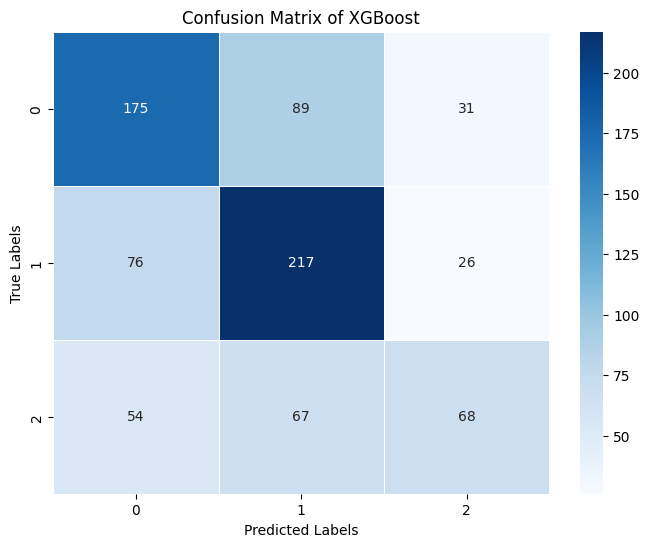

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

# Chạy mô hình tối ưu nhất vừa tìm được trên tập test.
y_pred_test = xg_best_estimator_l1_l2.predict(X_test_matrix)

# Tính các độ đo performance
xgboost_accuracy = accuracy_score(y_test, y_pred_test)
xgboost_precision = precision_score(y_test, y_pred_test, average='weighted')
xgboost_recall = recall_score(y_test, y_pred_test, average='weighted')
xgboost_f1 = f1_score(y_test, y_pred_test, average='weighted')

# Tạo Confusion Matrix
cm = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", linewidths=.5)
plt.title('Confusion Matrix of XGBoost')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.savefig('xgboost-conf.pdf', bbox_inches='tight')
# plt.show()

Các Tham Số Tốt Nhất: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'reg_alpha': 0.1, 'reg_lambda': 0.5}


## 2. Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
!pip install --upgrade scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 19.5 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2


In [ ]:
# Tạo một đối tượng CountVectorizer để chuyển đổi văn bản thành ma trận đặc trưng
vectorizer = CountVectorizer(lowercase=True, stop_words='english')

# Chuyển đổi những câu được tokenize thành một đoạn text
X_train_text = [' '.join(word) for word in X_train]
X_val_text = [' '.join(word) for word in X_val]
X_test_text = [' '.join(word) for word in X_test]

In [ ]:
# Chuyển đổi dữ liệu văn bản thành ma trận đặc trưng
X_train_vec = vectorizer.fit_transform(X_train_text)
X_val_vec = vectorizer.transform(X_val_text)
X_test_vec = vectorizer.transform(X_test_text)

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report

# Define the parameter grid
param_grid = {
    'C': [None, 0.01, 0.1, 1, 10],
    'max_iter': [100, 500, 1000]
}

# Create a Logistic Regression model
log_classifier = LogisticRegression()

# GridSearchCV
grid_search = GridSearchCV(
    estimator=log_classifier,
    param_grid=param_grid,
    scoring='accuracy',
    cv=3,
    verbose=1)

# Train GridSearchCV on the training data
grid_search.fit(X_train_vec, y_train)

# Get the best parameters
best_params = grid_search.best_params_
best_estimator = grid_search.best_estimator_

print("Best Parameters:", best_params)

Fitting 3 folds for each of 15 candidates, totalling 45 fits


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/usr/local/lib/python3.10/dist-packages/sklearn/

Best Parameters: {'C': 0.1, 'max_iter': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



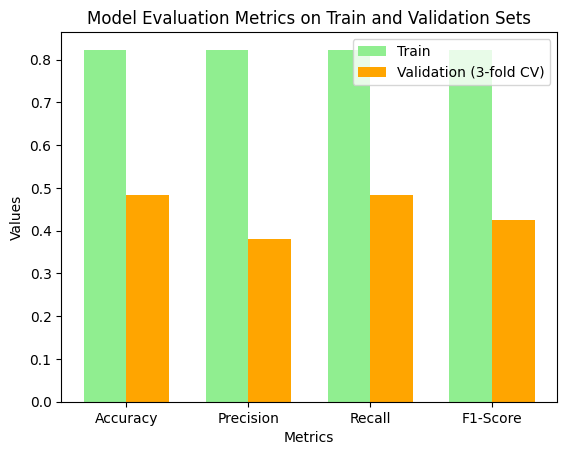

In [ ]:
from sklearn.model_selection import cross_val_predict

# Chạy mô hình tối ưu nhất vừa tìm được trên tập test.
y_pred_train = best_estimator.predict(X_train_vec)

# Đánh giá mô hình trên tập train
y_pred_train = best_estimator.predict(X_train_vec)
accuracy_train = accuracy_score(y_train, y_pred_train)
precision_train = precision_score(y_train, y_pred_train, average='weighted')
recall_train = recall_score(y_train, y_pred_train, average='weighted')
f1_train = f1_score(y_train, y_pred_train, average='weighted')

# Đánh giá mô hình trên tập validation (sử dụng 3-fold cross-validation)
y_pred_val_cv = cross_val_predict(best_estimator, X_val_vec, y_val, cv=3)
accuracy_val_cv = accuracy_score(y_val, y_pred_val_cv)
precision_val_cv = precision_score(y_val, y_pred_val_cv, average='weighted')
recall_val_cv = recall_score(y_val, y_pred_val_cv, average='weighted')
f1_val_cv = f1_score(y_val, y_pred_val_cv, average='weighted')

# Xây dựng mảng chứa các giá trị đánh giá
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
train_values = [accuracy_train, precision_train, recall_train, f1_train]
val_values = [accuracy_val_cv, precision_val_cv, recall_val_cv, f1_val_cv]

# Tạo bar chart
bar_width = 0.35
index = np.arange(len(metrics))

plt.bar(index, train_values, bar_width, label='Train', color='lightgreen')
plt.bar(index + bar_width, val_values, bar_width, label='Validation (3-fold CV)', color='orange')

plt.xlabel('Metrics')
plt.ylabel('Values')
plt.title('Model Evaluation Metrics on Train and Validation Sets')
plt.xticks(index + bar_width / 2, metrics)
plt.legend()
plt.savefig('logistic-trainval.pdf', bbox_inches='tight')
# plt.show()

### Regularized của Logistic Regression (L1)

In [ ]:
# Sử dụng best_params từ grid_search hoặc chỉ đơn giản là cung cấp giá trị bạn muốn
best_params = {'C': 0.1, 'max_iter': 100}

# Thêm L1 regularization và sử dụng solver 'liblinear'
best_estimator_l1 = LogisticRegression(penalty='l1', solver='liblinear', **best_params)

# Huấn luyện mô hình mới với L1 regularization và solver 'liblinear' trên dữ liệu huấn luyện
best_estimator_l1.fit(X_train_vec, y_train)

LogisticRegression(C=0.1, penalty='l1', solver='liblinear')

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



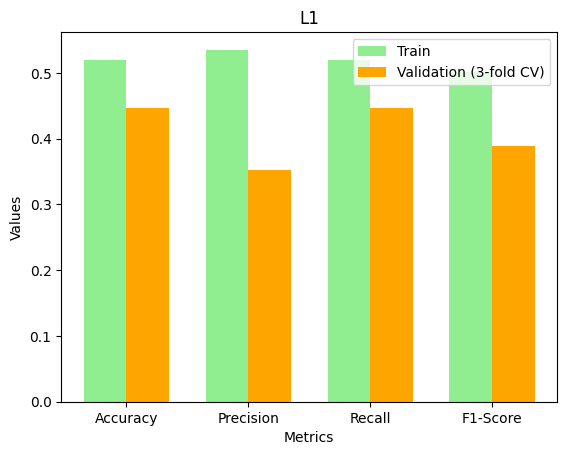

In [ ]:
from sklearn.model_selection import cross_val_predict


# Đánh giá mô hình trên tập train
y_pred_train = best_estimator_l1.predict(X_train_vec)
accuracy_train = accuracy_score(y_train, y_pred_train)
precision_train = precision_score(y_train, y_pred_train, average='weighted')
recall_train = recall_score(y_train, y_pred_train, average='weighted')
f1_train = f1_score(y_train, y_pred_train, average='weighted')

# Đánh giá mô hình trên tập validation (sử dụng 3-fold cross-validation)
y_pred_val_cv = cross_val_predict(best_estimator_l1, X_val_vec, y_val, cv=3)
accuracy_val_cv = accuracy_score(y_val, y_pred_val_cv)
precision_val_cv = precision_score(y_val, y_pred_val_cv, average='weighted')
recall_val_cv = recall_score(y_val, y_pred_val_cv, average='weighted')
f1_val_cv = f1_score(y_val, y_pred_val_cv, average='weighted')

# Xây dựng mảng chứa các giá trị đánh giá
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
train_values = [accuracy_train, precision_train, recall_train, f1_train]
val_values = [accuracy_val_cv, precision_val_cv, recall_val_cv, f1_val_cv]

# Tạo bar chart
bar_width = 0.35
index = np.arange(len(metrics))

plt.bar(index, train_values, bar_width, label='Train', color='lightgreen')
plt.bar(index + bar_width, val_values, bar_width, label='Validation (3-fold CV)', color='orange')

plt.xlabel('Metrics')
plt.ylabel('Values')
plt.title('L1')
plt.xticks(index + bar_width / 2, metrics)
plt.legend()
plt.savefig('logistic-l1.pdf', bbox_inches='tight')
# plt.show()

### Regularized của Logistic Regression (L2)

In [ ]:
# Sử dụng best_params từ grid_search hoặc chỉ đơn giản là cung cấp giá trị bạn muốn
best_params = {'C': 0.1, 'max_iter': 100}

# Thêm L1 regularization và sử dụng solver 'liblinear'
best_estimator_l2 = LogisticRegression(penalty='l2', solver='liblinear', **best_params)

# Huấn luyện mô hình mới với L1 regularization và solver 'liblinear' trên dữ liệu huấn luyện
best_estimator_l2.fit(X_train_vec, y_train)

LogisticRegression(C=0.1, solver='liblinear')

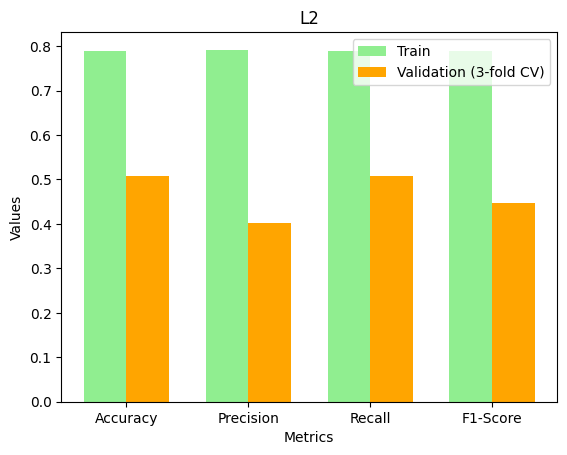

In [ ]:
from sklearn.model_selection import cross_val_predict

# Đánh giá mô hình trên tập train
y_pred_train = best_estimator_l2.predict(X_train_vec)
accuracy_train = accuracy_score(y_train, y_pred_train)
precision_train = precision_score(y_train, y_pred_train, average='weighted')
recall_train = recall_score(y_train, y_pred_train, average='weighted')
f1_train = f1_score(y_train, y_pred_train, average='weighted')

# Đánh giá mô hình trên tập validation (sử dụng 3-fold cross-validation)
y_pred_val_cv = cross_val_predict(best_estimator_l2, X_val_vec, y_val, cv=3)
accuracy_val_cv = accuracy_score(y_val, y_pred_val_cv)
precision_val_cv = precision_score(y_val, y_pred_val_cv, average='weighted')
recall_val_cv = recall_score(y_val, y_pred_val_cv, average='weighted')
f1_val_cv = f1_score(y_val, y_pred_val_cv, average='weighted')

# Xây dựng mảng chứa các giá trị đánh giá
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
train_values = [accuracy_train, precision_train, recall_train, f1_train]
val_values = [accuracy_val_cv, precision_val_cv, recall_val_cv, f1_val_cv]

# Tạo bar chart
bar_width = 0.35
index = np.arange(len(metrics))

plt.bar(index, train_values, bar_width, label='Train', color='lightgreen')
plt.bar(index + bar_width, val_values, bar_width, label='Validation (3-fold CV)', color='orange')

plt.xlabel('Metrics')
plt.ylabel('Values')
plt.title('L2')
plt.xticks(index + bar_width / 2, metrics)
plt.legend()
plt.savefig('logistic-l2.pdf', bbox_inches='tight')
# plt.show()

### Regularized của Logistic Regression (L1+L2)

In [ ]:
from sklearn.linear_model import LogisticRegression

# Sử dụng best_params từ grid_search hoặc chỉ đơn giản là cung cấp giá trị bạn muốn
best_params = {'C': 0.1, 'max_iter': 100, 'solver': 'saga', 'penalty': 'elasticnet', 'l1_ratio': 0.5}

# Tạo mô hình Logistic Regression với regularization Elastic Net
best_estimator_elasticnet = LogisticRegression(**best_params)

# Huấn luyện mô hình mới với Elastic Net regularization trên dữ liệu huấn luyện
best_estimator_elasticnet.fit(X_train_vec, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



LogisticRegression(C=0.1, l1_ratio=0.5, penalty='elasticnet', solver='saga')

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



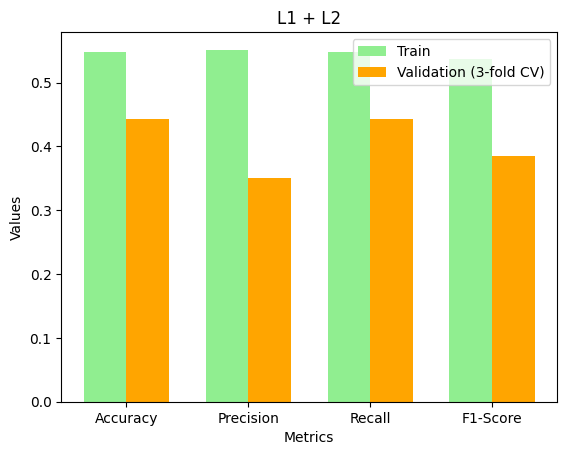

In [ ]:
from sklearn.model_selection import cross_val_predict

# Đánh giá mô hình trên tập train
y_pred_train = best_estimator_elasticnet.predict(X_train_vec)
accuracy_train = accuracy_score(y_train, y_pred_train)
precision_train = precision_score(y_train, y_pred_train, average='weighted')
recall_train = recall_score(y_train, y_pred_train, average='weighted')
f1_train = f1_score(y_train, y_pred_train, average='weighted')

# Đánh giá mô hình trên tập validation (sử dụng 3-fold cross-validation)
y_pred_val_cv = cross_val_predict(best_estimator_elasticnet, X_val_vec, y_val, cv=3)
accuracy_val_cv = accuracy_score(y_val, y_pred_val_cv)
precision_val_cv = precision_score(y_val, y_pred_val_cv, average='weighted')
recall_val_cv = recall_score(y_val, y_pred_val_cv, average='weighted')
f1_val_cv = f1_score(y_val, y_pred_val_cv, average='weighted')

# Xây dựng mảng chứa các giá trị đánh giá
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
train_values = [accuracy_train, precision_train, recall_train, f1_train]
val_values = [accuracy_val_cv, precision_val_cv, recall_val_cv, f1_val_cv]

# Tạo bar chart
bar_width = 0.35
index = np.arange(len(metrics))

plt.bar(index, train_values, bar_width, label='Train', color='lightgreen')
plt.bar(index + bar_width, val_values, bar_width, label='Validation (3-fold CV)', color='orange')

plt.xlabel('Metrics')
plt.ylabel('Values')
plt.title('L1 + L2')
plt.xticks(index + bar_width / 2, metrics)
plt.legend()
plt.savefig('logistic-l1l2.pdf', bbox_inches='tight')
# plt.show()


### Chạy trên tập Test

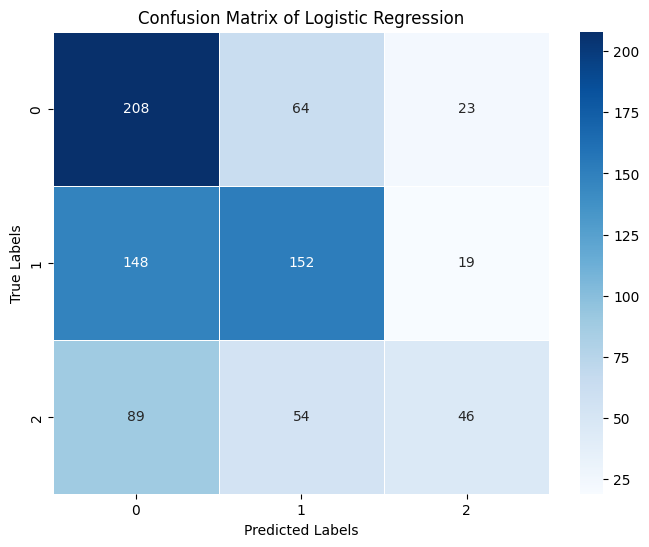

In [ ]:
# Chạy mô hình tối ưu nhất vừa tìm được trên tập test.
y_pred_test = best_estimator_l1.predict(X_test_vec)

# Tính các độ đo performance
log_accuracy = accuracy_score(y_test, y_pred_test)
log_precision = precision_score(y_test, y_pred_test, average='weighted')
log_recall = recall_score(y_test, y_pred_test, average='weighted')
log_f1 = f1_score(y_test, y_pred_test, average='weighted')

# Tạo Confusion Matrix
cm = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", linewidths=.5)
plt.title('Confusion Matrix of Logistic Regression')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.savefig('logistic-conf.pdf', bbox_inches='tight')
# plt.show()

## 3. BERT

**BERT** là một mô hình deep learning dựa trên cấu trúc Transformers, được sử dụng chủ yếu cho các tác vụ như phân tích cảm xúc (sentiment analysis), multiple choices, fake news detections...

Link paper gốc của BERT: https://arxiv.org/pdf/1810.04805.pdf

In [19]:
VER = 2
# TRAIN WITH SUBSET OF 60K
NUM_TRAIN_SAMPLES = 1_024

# PARAMETER EFFICIENT FINE TUNING
# PEFT REQUIRES 1XP100 GPU NOT 2XT4
USE_PEFT = True

# NUMBER OF LAYERS TO FREEZE
# BERT BASE HAS TOTAL OF 12 LAYERS
FREEZE_LAYERS = 12

# BOOLEAN TO FREEZE EMBEDDINGS
FREEZE_EMBEDDINGS = True

# LENGTH OF CONTEXT PLUS QUESTION ANSWER
MAX_INPUT = 512

# HUGGING FACE MODEL
MODEL = 'bert-base-uncased' # 'microsoft/deberta-v3-xsmall'

In [11]:
model = AutoModelForSequenceClassification.from_pretrained("leroyrr/bert-base-head", num_labels=3)
tokenizer = AutoTokenizer.from_pretrained(MODEL)

In [18]:
ptoi = {-1: 0, 0: 1, 1: 2}
def tokenize_function(example):
    example['label'] = [ptoi[p] for p in example['polarity']]
    return tokenizer(example['sentence'], truncation=True)

tokenized_datasets = dataset.map(tokenize_function, remove_columns=['mention', 'polarity', 'from', 'to', 'sentence', 'id'], batched=True)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
print(tokenized_datasets)

Map:   0%|          | 0/8739 [00:00<?, ? examples/s]

Map:   0%|          | 0/803 [00:00<?, ? examples/s]

Map:   0%|          | 0/343 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 8739
    })
    test: Dataset({
        features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 803
    })
    validation: Dataset({
        features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 343
    })
})


In [7]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for name, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
            print(name)
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param:.4f}"
    )
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)

    f1 = f1_score(labels, preds, average="weighted", labels=np.unique(preds))
    acc = accuracy_score(labels, preds)
    prec = precision_score(labels, preds, average="weighted", labels=np.unique(preds))
    recall = recall_score(labels, preds, average="weighted", labels=np.unique(preds))

    return {"accuracy": acc, "precision" : prec, "recall" : recall, "f1": f1}

In [10]:
if USE_PEFT:
    print('We are using PEFT.')
    from peft import LoraConfig, get_peft_model, TaskType
    peft_config = LoraConfig(
        r=8, lora_alpha=8, task_type=TaskType.SEQ_CLS, lora_dropout=0.1,
        bias="none", inference_mode=False,
        target_modules=["query", "value"],
        modules_to_save=['classifier', 'pooler'],
    )
    # model = AutoModelForSequenceClassification.from_pretrained('leroyrr/bert-base-head', num_labels=3)
    model = get_peft_model(model, peft_config)
    model.print_trainable_parameters()

We are using PEFT.
trainable params: 887,811 || all params: 110,372,358 || trainable%: 0.8043780309559029


In [16]:
if FREEZE_EMBEDDINGS:
    print('Freezing embeddings.')
    for param in model.bert.embeddings.parameters():
        param.requires_grad = False

if FREEZE_LAYERS > 0:
    print(f'Freezing {FREEZE_LAYERS} layers.')
    for layer in model.bert.encoder.layer[:FREEZE_LAYERS]:
        for param in layer.parameters():
            param.requires_grad = False
print_trainable_parameters(model)

Freezing embeddings.
Freezing 12 layers.
bert.pooler.dense.weight
bert.pooler.dense.bias
classifier.weight
classifier.bias
trainable params: 592899 || all params: 109484547 || trainable%: 0.5415


- Head: trainable params: trainable params: 592899 || all params: 124647939 || trainable%: 0.4757
BATCH_SIZE = 32,
LR = 2e-4,
WEIGHT_DECAY = 0.1,
EPOCHS = 5,
WARM_UP_RATIO = 0.06,

- Lora: trainable params: 887,811 || all params: 125,535,750 || trainable%: 0.7072176650874352 || BATCH_SIZE = 16
LR = 2e-4
WEIGHT_DECAY = 0.1
EPOCHS = 8
WARM_UP_RATIO = 0.06

- Full fine-tuning: trainable params: 124647939 || all params: 124647939 || trainable%: 100.0000

In [ ]:
torch.cuda.empty_cache()
# del model
# del head
# del roberta

In [ ]:
from transformers import TrainingArguments, Trainer

BATCH_SIZE = 16
LR = 1e-5
WEIGHT_DECAY = 0.1
EPOCHS = 8
WARM_UP_RATIO = 0.06

logging_steps = 2

output_name = f"finetuned-model"

training_args = TrainingArguments(output_dir=output_name,
                                per_device_train_batch_size=BATCH_SIZE,
                                per_device_eval_batch_size=BATCH_SIZE,

                                # For efficient training time and memory
                                dataloader_pin_memory=True,
                                dataloader_num_workers=2,
                                gradient_accumulation_steps=1,
                                fp16=True,

                                # Training hyperparameters
                                num_train_epochs=EPOCHS,
                                learning_rate=LR,
                                weight_decay=WEIGHT_DECAY,
                                warmup_ratio=WARM_UP_RATIO,

                                # Other parameters
                                evaluation_strategy="epoch",
                                save_strategy="epoch",
                                disable_tqdm=False,
                                logging_steps=logging_steps,
                                logging_first_step=True,
                                push_to_hub=False,
                                save_total_limit=8,
                                load_best_model_at_end=True)

trainer = Trainer(model=model,
                args=training_args,
                compute_metrics=compute_metrics,
                train_dataset=tokenized_datasets["train"],
                eval_dataset=tokenized_datasets["validation"],
                data_collator=data_collator,
                tokenizer=tokenizer)

trainer.train()

You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.658900,0.574425,0.772595,0.772815,0.772595,0.772696
2,0.588400,0.517533,0.781341,0.782029,0.781341,0.780076
3,0.432700,0.537532,0.816327,0.816025,0.816327,0.814952
4,0.389600,0.551797,0.813411,0.812999,0.813411,0.810901
5,0.368000,0.658582,0.793003,0.796025,0.793003,0.788369
6,0.334600,0.629482,0.813411,0.811435,0.813411,0.811876
7,0.115900,0.735299,0.804665,0.804140,0.804665,0.801514
8,0.293500,0.764828,0.813411,0.811692,0.813411,0.812125


You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
Checkpoint destination directory finetuned-model/checkpoint-547 already exists and is non-empty.Saving will proceed but saved results may be invalid.
You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text

TrainOutput(global_step=4376, training_loss=0.4134141441512941, metrics={'train_runtime': 615.2221, 'train_samples_per_second': 113.637, 'train_steps_per_second': 7.113, 'total_flos': 2683282023329544.0, 'train_loss': 0.4134141441512941, 'epoch': 8.0})

### Push model to hub

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
roberta.push_to_hub("roberta-ulmfit")

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/leroyrr/roberta-ulmfit/commit/92bb8bf26e6bbe0e5f3c5e05f6a473ff6d13deb2', commit_message='Upload RobertaForSequenceClassification', commit_description='', oid='92bb8bf26e6bbe0e5f3c5e05f6a473ff6d13deb2', pr_url=None, pr_revision=None, pr_num=None)

In [ ]:
ulmfit = AutoModelForSequenceClassification.from_pretrained("leroyrr/roberta-ulmfit").to(device)

config.json:   0%|          | 0.00/917 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

### Evaluate BERT using multiple finetune techniques

In [22]:
models = ['leroyrr/bert-base-head', 'leroyrr/bert-base-ulmfit', 'leroyrr/bert-for-political-news-sentiment-analysis-lora']
model_names = ["BERT model (Finetune Head only)", "BERT model (ULMFiT + Full Fine-tuning)", "BERT model (ULMFiT + LoRA)"]

def get_models(models):
    eval_models = []
    for model in models:
        bert = AutoModelForSequenceClassification.from_pretrained(model, num_labels=3).to(device)
        eval_models.append(bert)
    return eval_models
models = get_models(models)

config.json:   0%|          | 0.00/904 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

adapter_config.json:   0%|          | 0.00/600 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/3.56M [00:00<?, ?B/s]

In [23]:
from torch.nn.functional import softmax
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

itop = {0: "negative", 1: "neutral", 2: "positive"}
polarity = ["neg", "neu", "pos"]

def calc_metrics(text, labels, model):
    # Ensure the model is in evaluation mode
    model.eval()

    # Encode the text
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512).to(device)

    # Predict
    with torch.no_grad():
        logits = model(**inputs).logits

    preds = torch.argmax(logits, dim=1).tolist()

    # Compute metrics
    accuracy = accuracy_score(labels, preds)
    precision = precision_score(labels, preds, average='weighted')
    recall = recall_score(labels, preds, average='weighted')
    f1 = f1_score(labels, preds, average='macro')
    conf_matrix = confusion_matrix(labels, preds)

    return accuracy, precision, recall, f1, conf_matrix

# Example usage
text = dataset['validation']['sentence']
labels = tokenized_datasets['validation']['label']

# Compute metrics for each model
# calc_metrics(text, labels, ulmfit)
# metrics_list = [calc_metrics(text, labels, model) for model in models]

head

(0.6997084548104956,
 0.6956255095404154,
 0.6997084548104956,
 0.6729529335912314,
 array([[102,  20,  12],
        [ 23, 102,  11],
        [ 13,  24,  36]]))

lora

0.8017492711370262,
 0.8006845676785833,
 0.8017492711370262,
 0.7817242834945525,

 0.8163265306122449,
 0.8131426439271371,
 0.8163265306122449,
 0.7938248024911481,

 ulmfit

 0.8134110787172012,
 0.8129994745676807,
 0.8134110787172012,
 0.7970516762379823,

In [ ]:
def plot_confusion_matrices(model_names, metrics_list):
    plt.figure(figsize=(6, 5 * len(model_names)))  # Adjust this as needed

    for idx, (accuracy, precision, recall, f1, conf_matrix) in enumerate(metrics_list):
        ax = plt.subplot(len(model_names), 1, idx+1)
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=polarity, yticklabels=polarity, annot_kws={"size": 10})
        plt.xlabel('Predicted', fontsize=7)
        plt.ylabel('True', fontsize=7)
        plt.xticks(fontsize=7)
        plt.yticks(fontsize=7)
        plt.title(f'{model_names[idx]} Confusion Matrix', fontsize=7)
        # plt.savefig(f"model{idx}.pdf", bbox_inches="tight")

        print(f"Metrics for {model_names[idx]}:")
        print("-----------------------------")
        print(f"Accuracy: \t {accuracy:.5f}")
        print(f"Precision: \t {precision:.5f}")
        print(f"Recall: \t {recall:.5f}")
        print(f"F1-score: \t {f1:.5f}")
        print("-----------------------------")
        print()

    plt.tight_layout()
    plt.show()

# Example usage
text = dataset['test']['sentence']
labels = tokenized_datasets['test']['label']

# Compute metrics for each model
metrics_list = [calc_metrics(text, labels, model) for model in models]

# Plot confusion matrices
plot_confusion_matrices(model_names, metrics_list)

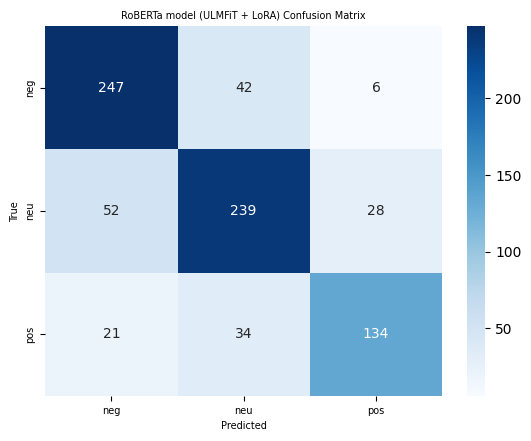

In [ ]:
idx = 2
accuracy, precision, recall, f1, conf_matrix = metrics_list[idx]
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=polarity, yticklabels=polarity, annot_kws={"size": 10})
plt.xlabel('Predicted', fontsize=7)
plt.ylabel('True', fontsize=7)
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
plt.title(f'{model_names[idx]} Confusion Matrix', fontsize=7)
plt.savefig(f"model{idx}.pdf", bbox_inches="tight")

## So sánh và đánh giá:

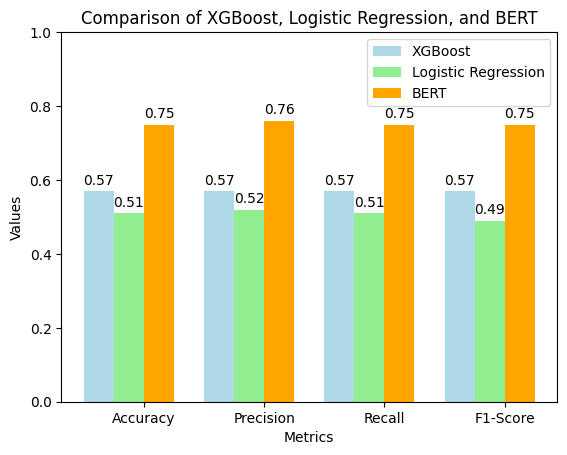

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Metrics and values for plotting
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
# xgboost_values = [xgboost_accuracy, xgboost_precision, xgboost_recall, xgboost_f1]
# log_values = [log_accuracy, log_precision, log_recall, log_f1]
xgboost_values = [0.57, 0.57, 0.57, 0.57]
log_values = [0.51, 0.52, 0.51, 0.49]
roberta_values = [0.75, 0.76, 0.75, 0.75]

# Plotting
bar_width = 0.25
index = np.arange(len(metrics))

plt.bar(index, xgboost_values, bar_width, label='XGBoost', color='lightblue')
plt.bar(index + bar_width, log_values, bar_width, label='Logistic Regression', color='lightgreen')
plt.bar(index + 2*bar_width, roberta_values, bar_width, label='BERT', color='orange')

# Add numerical values on top of each bar
for i, value in enumerate(xgboost_values):
    plt.text(i, value + 0.01, f'{value:.2f}', ha='center', va='bottom', color='black')

for i, value in enumerate(log_values):
    plt.text(i + bar_width, value + 0.01, f'{value:.2f}', ha='center', va='bottom', color='black')

for i, value in enumerate(roberta_values):
    plt.text(i + 2*bar_width, value + 0.01, f'{value:.2f}', ha='center', va='bottom', color='black')

plt.xlabel('Metrics')
plt.ylabel('Values')
plt.title('Comparison of XGBoost, Logistic Regression, and BERT')
plt.xticks(index + 1.5*bar_width, metrics)
plt.ylim(0, 1)
plt.legend()
plt.savefig('compare-model.pdf', bbox_inches='tight')
# plt.show()

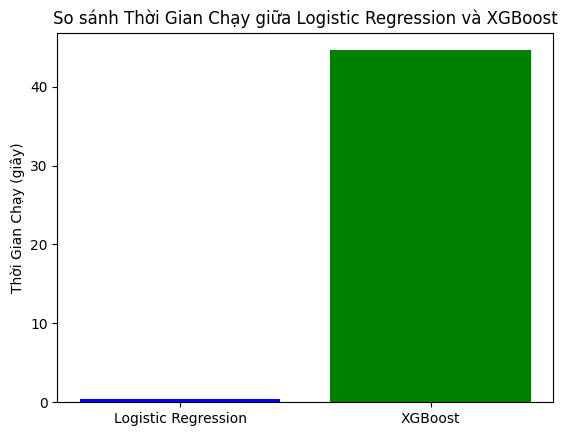

In [ ]:
import time

# Khởi tạo mô hình Logistic Regression với các tham số tốt nhất
logreg_model = LogisticRegression(C=0.1, penalty='l1', solver='liblinear')

# Ghi lại thời điểm bắt đầu của Logistic Regression
start_time_logreg = time.time()

# Huấn luyện mô hình Logistic Regression
logreg_model.fit(X_train_vec, y_train)
end_time_logreg = time.time()
execution_time_logreg = end_time_logreg - start_time_logreg

# Khởi tạo mô hình XGBoost với các tham số tốt nhất
xg_best_estimator_l1_l2 = XGBClassifier(
    learning_rate=0.1,
    max_depth=7,
    n_estimators=200,
    reg_alpha=0.1,
    reg_lambda=0.5,
)

# Ghi lại thời điểm bắt đầu của XGBoost
start_time_xgboost = time.time()
xg_best_estimator_l1_l2.fit(X_train_matrix, y_train)
end_time_xgboost = time.time()
execution_time_xgboost = end_time_xgboost - start_time_xgboost

# Hiển thị kết quả trên biểu đồ
models = ['Logistic Regression', 'XGBoost']
execution_times = [execution_time_logreg, execution_time_xgboost]
plt.bar(models, execution_times, color=['lightblue', 'lightgreen'])
plt.ylabel('Thời Gian Chạy (giây)')
plt.title('So sánh Thời Gian Chạy giữa Logistic Regression và XGBoost')
plt.show()


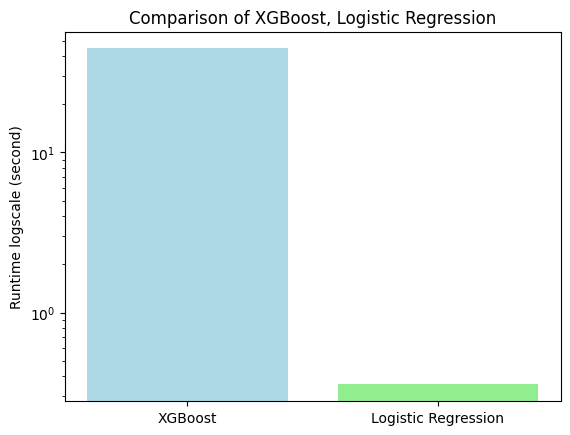

In [ ]:
# Thời gian chạy của mô hình XGBoost và Logistic Regression
execution_times = [44.59901022911072, 0.35511207580566406]
models = ['XGBoost', 'Logistic Regression']

# Hiển thị kết quả trên biểu đồ với trục y ở định dạng logarithmic
plt.bar(models, execution_times, color=['lightblue', 'lightgreen'])
plt.ylabel('Runtime logscale (second)')
plt.yscale('log')
plt.title('Comparison of XGBoost, Logistic Regression')
plt.show()